# Christopher Prince [cmp670@nyu.edu]
## MATH.2012 HW 1

### _Preliminaries_

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import pylab as pl
%matplotlib inline

## Source files and reproducibility

The program has been packaged with a make file and a bash script to run the experiment on a given machine. The process is:

* Copy `makefile`, `runlaplace.sh`, and `laplace-iter.c` into a directory. The easiest way to do this is to clone the github repo cmprince/hpc17 (files are in the hw1 directory).
* Run `make`. This will generate four versions of the laplace iteration program with optimization levels 0, 1, 2 and 3.
* Run `runlaplace.sh` (if necessary change file permissions). This runs each level of optimization for both Gauss-Seidel and Jacobi iterations for $N \in \{100, 1000, 10000, 100000\}$, repeating 10 times, and writes the results of each run to a file.

### makefile
----

```bash
PROGRAM = laplace-iter

all:
	for i in 0 1 2 3 ; do \
		$(CC) -o $(PROGRAM)O$$i -std=gnu99 $(PROGRAM).c -lm -lrt -Wall -O$$i; \
	done
```

### runlaplace.sh
----

```bash
#!/bin/bash
THISHOST=$(hostname -s)

for j in "j" "g"                # jacobi and gauss-seidel
do
    for opt in {0..3}             # optimization level
    do
        for size in 100 1000 10000 100000
        do

            ((num = 0))
            ((result = 0))
            for i in {1..10}         # iterations
            do
                ((num = $(./laplace-iterO$opt $size $j)))
                ((result += num))
                echo $opt $size $i $num >> ${j}_${THISHOST}
            done
        done
    done
done
```

### laplace-iter.c
----

```c
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <string.h>
#include "util.h"

/* Christopher Prince [cmp670@nyu.edu], 2017
 *
 * A naive numerical solver for solving the 1-D Laplace boundary value problem
 *    -u'' = f,
 *    u(0) = 0, u(1) = 0
 *    f = 1
 *
 * The finite difference approximation for the second derivative is given by
 *    -u''(x_i) ≈ (1/2) * [-u(x_(i-1)) + 2*(u(x_(i))) - u(x_(i+1))]
 * with index i in [0, N-1] for N grid points.
 *
 * This establishes N equations expressed in matrix form as:
 *     (N*N)*Au = f  ==>  Au = f/(N*N)
 * with A the NxN tridiagonal matrix with 2's on the main diagonal, 
 * -1's on the adjacent diagonals, and 0's elsewhere.
 * 
 * Goodness of fit at the k'th iteration is reported as the L2 norm of Au[k] - f.
 *
 * In this implementation, the user can choose between Jacobi and Gauss-Seidel
 * iterative methods using a command line argument ("j" or "g")
 *
 * Usage:
 *
 * $ laplace-iter [N_gridpoints [method [max_iterations [reduction_factor]]]]
 * All options are optional (but must be given in this order), with default arguments
 *     N = 1000
 *     method = "j"
 *     max_iterations = 1000
 *     reduction_factor = 0.0001
 *
 * */

double laplace_L2_norm(double *v, int len);
double *jacobi_iteration(double *u, int len);
double *gs_iteration(double *u, int len);

int main(int argc, char *argv[]){

    int N = 1000;
    char method[] = "j";
    int max_iter = 1000;
    double term_factor = 0.0001;
    char *end;                      //dummy pointer for strtoX()

    // This argument parser is not particularly robust...
    if (argc > 4)
        term_factor = strtod(argv[4], &end);
    if (argc > 3)
        max_iter = atoi(argv[3]);
    if (argc > 2)
        strncpy(method, argv[2], 1);
    if (argc > 1)
        N = atoi(argv[1]);

    if (method[0] != 'j' && method[0] != 'g'){
        fprintf(stderr, "Only valid methods are jacobi and gauss-seidel!\n");
        exit(-1);
    }

    timestamp_type t1, t2;
    get_timestamp(&t1);

    double *u;
    u = malloc(N * sizeof u);

    // initialize first estimate = 0
    for (int i=0; i<N; i++)  u[i] = 0.;
    
    double norm, norm0;

    // calculate L2 norm or residual for initial guess
    norm0 = laplace_L2_norm(u, N);
    norm = norm0;
    fprintf(stderr, "Norm of residual ||Au[0] - f|| = %.8f\n", norm0);

    for (int iter=1; (iter<=max_iter && norm/norm0 > term_factor); iter++){
        switch (method[0]){
            case 'j':
                u = jacobi_iteration(u, N);
                break;
            case 'g':
                u = gs_iteration(u, N);
                break;
        }

        norm = laplace_L2_norm(u, N);
        fprintf(stderr, "Norm of residual ||Au[k] - f|| at iteration %i =  %.8f\n", 
                iter, norm);
    }

    get_timestamp(&t2);

    double elapsed_s = timestamp_diff_in_seconds(t1, t2);
    long elapsed = elapsed_s*1e6;
    fprintf(stderr, "Time elapsed is %li useconds.\n", elapsed);
    fprintf(stderr, "Time elapsed is %f seconds.\n", elapsed_s);
    printf("%li", elapsed);  //is there a better way to do this?

//    for (int i=0; i<N; i++) printf("%.3f\t", u[i]);
//    printf("\n");
    free(u);
    return (1);
}

double *jacobi_iteration(double *u, int len){
    /* Jacobi iterations:
     * u_i[k+1] = 1/a_ii (f_i - sum(a_ij*u_j[k]; j != i))
     *
     * With
     * a_ij = 2, i=j
     * a_ij = -1, (i-j)^2 = 1
     * a_ij = 0 otherwise
     * 
     * ==> u_i[k+1] = 1/2 (f_i + u_(i-1)[k] + u_(i+1)[k]) 
     */

    double *uu;
    uu = malloc(len * sizeof uu);     // uu is "updated u"

    uu[0] = 0.5*(1/(float)(len*len) + u[1]);
    for (int i=1; i<len-1; i++)
        uu[i] = 0.5*(1/(float)(len*len) + (u[i-1] + u[i+1]));
    uu[len-1] = 0.5*(1/(float)(len*len) + u[len-2]);

    //copy new vector uu into u for next iteration
    for (int i=0; i<len; i++)  u[i]=uu[i];
    
    free(uu);

    return u;
}

double *gs_iteration(double *u, int len){
    /* Gauss-Seidel iterations:
     * u_i[k+1] = 1/a_ii (f_i - (sum(a_ij*u_j[k+1]; j < i) + sum(a_ij*u_j[k]; j > i))
     *
     * With
     * a_ij = 2, i=j
     * a_ij = -1, (i-j)^2 = 1
     * a_ij = 0 otherwise
     * 
     * ==> u_i[k+1] = 1/2 (f_i + uu_(i-1)[k] + u_(i+1)[k])
     * 
     * This can be updated in-place, so we don't need to create 
     * a separate update vector.
     */

    u[0] = 0.5*(1/(float)(len*len) + u[1]);
    for (int i=1; i<len-1; i++)
        u[i] = 0.5*(1/(float)(len*len) + (u[i-1] + u[i+1]));
    u[len-1] = 0.5*(1/(float)(len*len) + u[len-2]);

    return u;
}

double laplace_L2_norm(double *v, int len){

    //Compute sum of squares of elements in Au - f
    //Note term 1/h^2 (=N^2) in matrix A.
 
    double sumsq = 0;
    sumsq += pow(((2*v[0] - v[1])*(float)(len*len) - 1), 2);
    for (int i=1; i<len-1; i++)
        sumsq += pow(((-v[i-1] + 2*v[i] -v[i+1])*(float)(len*len) - 1), 2);
    sumsq += pow(((-v[len-2] + 2*v[len-1])*(float)(len*len) - 1), 2);

    //The L2 norm is the square root of this sum:
    return sqrt(sumsq);
}
```

----

## Architectures

The tests were run on 9 different machines: my personal laptop, a server at NYU-CUSP, and seven servers at CIMS. Two of the CIMS servers, crunchy5 and crunchy6, have identical specifications and was used to see how repeatable the results between machines with the same specifications. The specifications for the CUSP server was obtained from datahub.cusp.nyu.edu, and for the CIMS server from cims.nyu.edu.

| Machine  | Owner | Processor        | No. Processors | No. Cores/Proc. | Freq. (GHz) | Memory (GB) | Operating System |
|----------|-------|------------------|----------------|-----------------|-------------|-------------|----|
| brawler  | CIMS  | AMD Opteron      | 2              | 2               | 2.6         | 8           | RHEL Server 6.8
| compute  | CUSP  | Xeon E5-4640     | 4              | 8               | 2.40        | 1024        | Oracle Linux Server 6.4
| crackle4 | CIMS  | Xeon E5630       | 2              | 8               | 2.53        | 16          | CentOS 7
| crunchy4 | CIMS  | AMD Opteron 6136 | 4              | 8               | 2.4         | 128         | RHEL Server 6.8
| crunchy5 | CIMS  | AMD Opteron 6272 | 4              | 16              | 2.1         | 256         | RHEL Server 6.8
| crunchy6 | CIMS  | AMD Opteron 6272 | 4              | 16              | 2.1         | 256         | RHEL Server 6.8
| energon2 | CIMS  | Xeon L5320       | 2              | 4               | 1.86        | 8           | RHEL Server 6.8
| laptop   | Me    | Xeon E3-1505M v5 | 1              | 4               | 2.80        | 64          | Ubuntu 16.04 LTS
| snappy5  | CIMS  | Xeon E5-2680     | 2              | 10              | 2.80        | 128         | CentOS 7

## Results and observations

### Convergence
We first note that the residual error for the Jacobi iteration method for $N=1000$ is reduced from 31.6 at iteration 0 to 30.5 at iteration 1,000. For Gauss-Seidel, it is reduced to 30.0. So we can verify that Gauss-Seidel converges at a faster rate than Jacobi.

For $N=100000$, both methods are very slow. For Jacobi, the residual reduces from 316.23 to 316.12. For Gauss-Seidel, it reduces to 316.07.

For both sizes of $N$, the iteration count causes the program to stop, not the improvement in residual.

### Timing results
The results files are space-delimited with the following columns:

In [3]:
names=['OptLevel','N','run','usec']

Uncomment the cell below to retrieve the sample data used in this notebook:

In [5]:
#!wget -r -l1 -np -nd -R index.html?*,html -e robots=off https://www.cims.nyu.edu/~cmp670/hw1_output/

Read the files in as dataframes and merge the timing columns, starting with Gauss-Seidel:

In [215]:
gb = pd.read_csv("g_laptop", header=None, delimiter=" ", names=names).drop("usec", axis=1)

In [216]:
for f in sorted(os.listdir('.')):
    if f[:2]=="g_":
        g = pd.read_csv(f, header=None, delimiter=" ", names=names[:-1] + [f])
        gb = gb.merge(g, on=names[:-1])

There are a few runs where the timing is much greater than the others; instead of taking a mean value over the runs I calculate the median run time here.

In [217]:
g = gb.groupby(names[:2][::-1]).aggregate(np.median).drop("run", axis=1)
g

g_brawler  g_compute  g_crackle4  g_crunchy4  g_crunchy5  \
N      OptLevel                                                             
100    0            6594.5     5400.0     11754.5      7404.5      7544.5   
       1            5295.0     5855.5      9380.5      4875.0      6366.5   
       2            4920.0     4647.5      8362.5      5103.5      5934.5   
       3            4426.5     4865.5      9581.0      4890.5      4922.0   
1000   0           31263.0    23965.5     36517.5     28770.0     37419.0   
       1           15431.0    13438.5     18763.5     16024.0     18080.0   
       2           15553.5    12747.0     17123.5     15865.5     18711.5   
       3           11916.5    10680.0     16415.0     12010.0     13089.5   
10000  0          270740.0   194952.5    280135.5    253072.0    338330.5   
       1          117430.5    91622.5     93729.5    120442.5    144213.0   
       2          119547.5    93577.5     94648.0    119746.0    145021.5   
       3           81617.0    66398.0     67250.0     81686.0     89790.0   
100000 0         2674826.5  1892177.5   2716565.5   2505563.0   3312446.0   
       1         1178014.0   902902.0    853775.5   1214029.5   1398318.0   
       2         1178344.5   900135.5    853757.0   1204965.0   1403364.5   
       3          811488.0   637286.0    592262.0    785880.5    858290.0   

                 g_crunchy6  g_energon2   g_laptop  g_snappy5  
N      OptLevel                                                
100    0             7511.0      8811.0     4949.0     8307.5  
       1             5939.5      6697.0     4051.5     6167.5  
       2             6749.0      6665.0     3694.5    12953.0  
       3             6091.0      6255.5     2705.5     5933.5  
1000   0            37709.0     39921.5    31913.0    26060.5  
       1            18798.5     18928.5    21905.0    16169.0  
       2            19795.0     18602.0    26838.0    31814.5  
       3            14253.0     15555.0    11454.0    11724.0  
10000  0           337462.5    333473.5   297733.5   195833.0  
       1           143759.5    131169.0   151363.5    69510.0  
       2           144843.0    130204.5   147989.5    69560.0  
       3            89586.0     96585.0    93882.0    52504.5  
100000 0          3351598.0   3233742.5  2763139.0  1872086.0  
       1          1396994.0   1236819.5  1423082.5   627741.0  
       2          1401539.5   1229964.0  1398591.0   627799.0  
       3           855627.5    904581.0   895479.0   459182.0

We can see that crunchy5 and crunchy6 do indeed run at similar rates. In common with the other machines, though, there is much more variability in the smaller $N$ cases than in the larger cases.

Notably, my laptop does a pretty decent job keeping up with some of the servers. Because it's running a graphical interface and is not a dedicated server, I do not know how my background programs are influencing the performance.

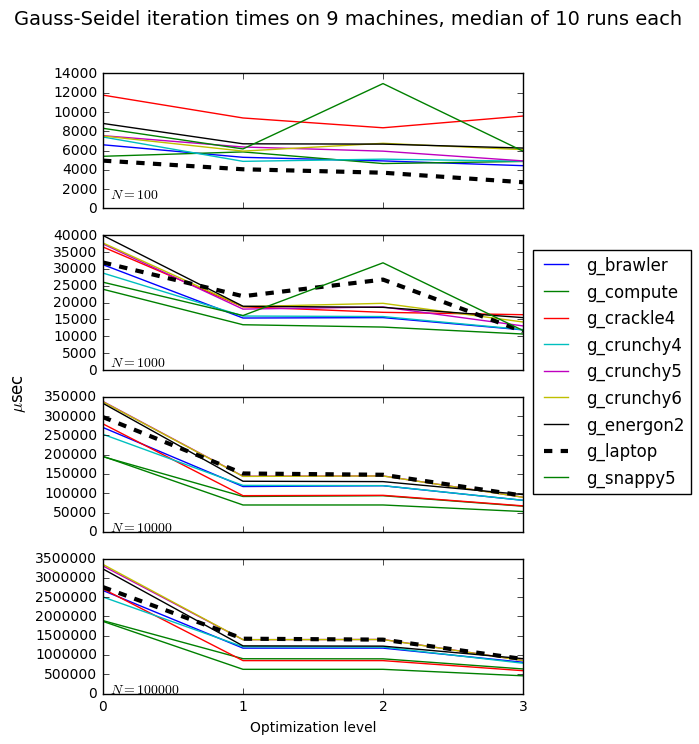

In [219]:
f, axarr = pl.subplots(4,1, figsize=(7,8), sharex=True)
f.subplots_adjust(left=0.15,right=0.75)
for i in range(4):
    lines = axarr[i].plot(g.loc[10**(i+2)])
    pl.setp(lines[7], lw=3, ls='--', color='k')
    axarr[i].set_ylim(0, axarr[i].get_ylim()[1])
    axarr[i].text(0.05,1000,'$N={}$'.format(10**(i+2)))
f.legend(lines, g.columns, loc='right')
pl.xticks(range(4), range(4));
pl.xlabel('Optimization level')
pl.yticks;
f.text(0.03, 0.5, '$\mu$sec', ha='center', va='center', rotation='vertical', fontsize=12)
f.suptitle('Gauss-Seidel iteration times on 9 machines, median of 10 runs each', fontsize=14);

Repeating for Jacobi:

In [210]:
gb = pd.read_csv("j_laptop", header=None, delimiter=" ", names=names).drop("usec", axis=1)

In [211]:
for f in sorted(os.listdir('.')):
    if f[:2]=="j_":
        g = pd.read_csv(f, header=None, delimiter=" ", names=names[:-1] + [f])
        gb = gb.merge(g, on=names[:-1])

In [212]:
j=gb.groupby(names[:2][::-1]).aggregate(np.median).drop("run", axis=1)
j

j_brawler  j_compute  j_crackle4  j_crunchy4  j_crunchy5  \
N      OptLevel                                                             
100    0            7497.0     8061.0     12715.5      7812.0      8503.5   
       1            4466.5     4540.0      9505.5      4769.0      4808.5   
       2            5148.5     4739.5      9680.5      5017.0      4853.5   
       3            4508.5     4617.0      9427.5      5034.5      5737.5   
1000   0           37423.5    28733.5     40280.5     35393.0     42935.0   
       1           10187.5     8686.0     14234.0     11264.5      9868.0   
       2           10302.5     8674.0     15348.0     10648.5      9988.0   
       3            9844.5     8095.0     13401.0      9982.0      9277.0   
10000  0          331544.0   226258.5    320437.0    318153.5    392644.5   
       1           74920.0    43765.5     49395.0     60325.5     53111.5   
       2           74942.5    47806.0     56048.5     56792.5     53758.5   
       3           74622.0    41000.0     43743.5     57322.0     52501.0   
100000 0         3502820.5  2185905.5   3093707.0   3198982.5   3871167.5   
       1         1542728.5   439282.0    440913.0    696902.5    583553.0   
       2         1531587.0   443670.5    475749.0    681226.5    586427.0   
       3         1542900.0   430731.0    372329.0    700186.0    557806.5   

                 j_crunchy6  j_energon2   j_laptop  j_snappy5  
N      OptLevel                                                
100    0            10614.0      9778.0     9203.0    17029.5  
       1             6141.5      8394.5     4628.0     6157.5  
       2             6013.5      6496.5     3202.0     7955.0  
       3             5098.5      6527.5     2683.0    13504.0  
1000   0            64469.0     44715.5    35304.0    28090.5  
       1            11917.0     12757.0    22288.5    10025.0  
       2            10251.0     12668.5    26560.0    11281.0  
       3            10142.0     12519.0    11307.5    19600.5  
10000  0           392513.0    385069.0   309446.5   216754.0  
       1            56859.0     67053.0   135659.0    36599.5  
       2            55006.0     65882.5   140558.0    36493.5  
       3            53681.5     64934.5    78422.5    39692.0  
100000 0          3950237.5   3772834.0  2950856.5  2081199.5  
       1           745783.5   1754288.0  1325775.5   308127.5  
       2           592748.0   1748916.0  1316689.5   309115.0  
       3           571730.5   1737120.5   783812.0   279410.0

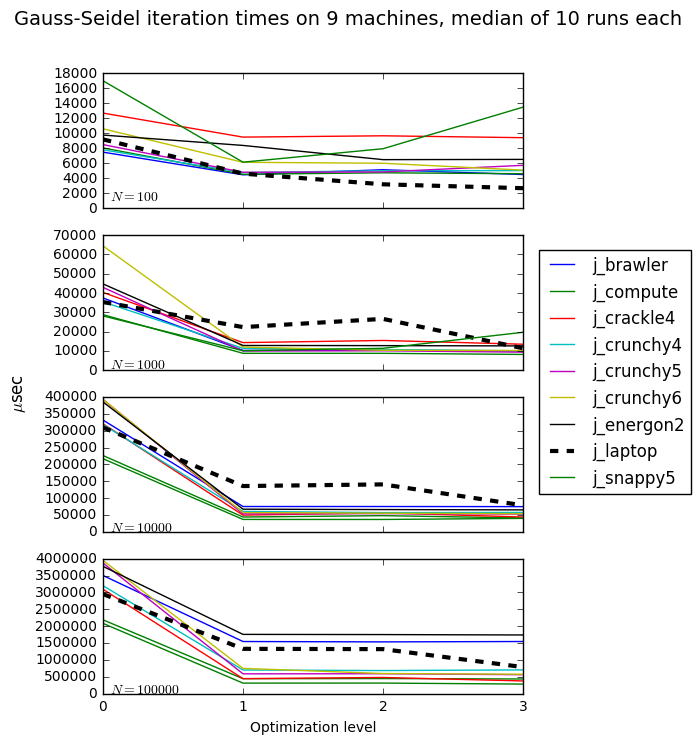

In [214]:
f, axarr = pl.subplots(4,1, figsize=(7,8), sharex=True)
f.subplots_adjust(left=0.15,right=0.75)
for i in range(4):
    lines = axarr[i].plot(j.loc[10**(i+2)])
    pl.setp(lines[7], lw=3, ls='--', color='k')
    axarr[i].set_ylim(0, axarr[i].get_ylim()[1])
    axarr[i].text(0.05,1000,'$N={}$'.format(10**(i+2)))
f.legend(lines, j.columns, loc='right')
pl.xticks(range(4), range(4));
pl.xlabel('Optimization level')
pl.yticks;
f.text(0.03, 0.5, '$\mu$sec', ha='center', va='center', rotation='vertical', fontsize=12)
f.suptitle('Gauss-Seidel iteration times on 9 machines, median of 10 runs each', fontsize=14);